# Variational Autoencoders 

**This Tutorial is adapted from [https://pyro.ai/examples/vae.html](https://pyro.ai/examples/vae.html)*

The variational autoencoder (VAE) is arguably the simplest deep probabilistic model. Note that VAE isn't a model as such — rather the VAE is a particular setup for doing variational inference for a certain class of models. The class of models is quite broad: basically any (unsupervised) density estimator with latent random variables. The basic structure of such a model is depicted in the Figure below.

<img src="images/vae_model.png" width="280" height="280"/>

Here we have depicted the structure of the kind of model we are interested in as a graphical model. We have $N$ observed datapoints $\{\boldsymbol{x}_i\}$. Each datapoint is generated by a (local) latent random variable $\boldsymbol{z}_i$. There is also a parameter $\theta$, which is global in the sense that all the datapoints depend on it (which is why it is drawn outside the plate). Note that since $\theta$ is a parameter, it's not something we're being Bayesian about. **What's of particular importance here is that we allow for each $\boldsymbol{x}_i$ to depend on $\boldsymbol{z}_i$ in a complex, non-linear way.** In practice this dependency will be parameterized by a (deep) neural network with parameters $\theta$. It is this non-linearity that makes inference for this class of models particularly challenging.

Of course this non-linear structure is also one reason why this class of models offers a very flexible approach to modeling complex data. Indeed it's worth emphasizing that each of the components of the model can be "reconfigured" in a variety of different ways. For example:

- the neural network in $p_{\theta}(\boldsymbol{x}\,|\, \boldsymbol{z})$ can be varied in all the usual ways (number of layers, type of non-linearities, number of hidden units, etc.)

- we can choose observation likelihoods that suit the dataset at hand: gaussian, bernoulli, categorical, etc.

- we can choose the number of dimensions in the latent space

The graphical model representation is a useful way to think about the structure of the model, but it can also be fruitful to look at an explicit factorization of the joint probability density:

$p({\bf x}, {\bf z}) = \prod_{i=1}^N p_\theta({\bf x}_i \,|\, {\bf z}_i) \, p({\bf z}_i)$

The fact that $p(\boldsymbol{x},\boldsymbol{z})$ breaks up into a product of terms like this makes it clear what we mean when we call $\boldsymbol{z}_i$ a local random variable. For any particular $i$, only the single datapoint $\boldsymbol{x}_i$ depends on $\boldsymbol{z}_i$. As such the $\boldsymbol{z}_i$ describe local structure, i.e. structure that is private to each data point. This factorized structure also means that we can do subsampling during the course of learning. As such this sort of model is amenable to the large data setting.

Recall that the job of the guide is to "guess" good values for the latent random variables — good in the sense that they're true to the model prior and true to the data. If we weren't making use of amortization, we would introduce variational parameters$ \{\lambda_i\}$ for each datapoint $\boldsymbol{x}_i$. These variational parameters would represent our belief about "good" values of $\boldsymbol{z}_i$; for example, they could encode the mean and variance of a gaussian distribution in $\boldsymbol{z}_i$ space. Amortization means that, rather than introducing variational parameters $\lambda_i$, we instead learn a function that maps each $\boldsymbol{x}_i$ to an appropriate $\lambda_i$. Since we need this function to be flexible, we parameterize it as a neural network. We thus end up with a parameterized family of distributions over the latent $\boldsymbol{z}$ space that can be instantiated for all $N$ datapoint $\boldsymbol{x}_i$.

<img src="images/vae_guide.png" width="280" height="280"/>

Note that the guide $q_{\varphi}(\boldsymbol{z}\,|\,\boldsymbol{x})$ is parameterized by a global parameter $\varphi$ shared by all the datapoints. The goal of inference will be to find "good" values for $\theta$ and $\varphi$ so that two conditions are satisfied:

- the log evidence $\log p_{\theta}(\boldsymbol{x})$ is large. this means our model is a good fit to the data
- the guide $q_{\varphi}(\boldsymbol{z}\,|\,\boldsymbol{x})$ provides a good approximation to the posterior

At this point we can zoom out and consider the high level structure of our setup. For concreteness, let's suppose the $\{\boldsymbol{x}_i\}$ are images so that the model is a generative model of images. Once we have learned a good value of $\theta$ we can generate images from the model as follows:

- sample $\boldsymbol{z}$ according to the prior $p(\boldsymbol{z})$.
- sample $\boldsymbol{x}$ according to the likelihood $p_{\theta}(\boldsymbol{x}\,|\,\boldsymbol{z})$.

Each image is being represented by a latent code $\boldsymbol{z}$ and that code gets mapped to images using the likelihood, which depends on the $\theta$ we've learned. This is why the likelihood is often called the decoder in this context: its job is to decode $\boldsymbol{z}$ into $\boldsymbol{x}$. Note that since this is a probabilistic model, there is uncertainty about the $\boldsymbol{z}$ that encodes a given datapoint $\boldsymbol{x}$.

Once we've learned good values for $\theta$ and $\varphi$ we can also go through the following exercise.

- We start with a given image $\boldsymbol{x}$.
- Using our guide we encode it as $\boldsymbol{z}$.
- Using the model likelihood we decode $\boldsymbol{z}$ and get a reconstructed image $\boldsymbol{x}_{reco}$.

If we've learned good values for $\theta$ and $\varphi$, $\boldsymbol{x}$ and $\boldsymbol{x}_{reco}$ should be similar. This should clarify how the word autoencoder ended up being used to describe this setup: the model is the decoder and the guide is the encoder. Together, they can be thought of as an autoencoder.

## Implementing VAEs

Let us see how we implement a VAE in Pyro. The dataset we are going to model is MNIST, a collection of images of handwritten digits. Since this is a popular benchmark dataset, we can make use of PyTorch's convenient data loader functionalities to reduce the amount of boilerplate code we need to write:

In [2]:
import os

import numpy as np
import torch
import torchvision.datasets as dset
import torch.nn as nn
import torchvision.transforms as transforms

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [5]:
pyro.enable_validation(True)
pyro.distributions.enable_validation(False)
pyro.set_rng_seed(0)

# Enable smoke test - run the notebook cells on CI.
smoke_test = 'CI' in os.environ

In [6]:
# for loading and batching MNIST dataset

def setup_data_loaders(batch_size=128, use_cuda=False):
    
    root         = './data'
    download     = True
    trans        = transforms.ToTensor()
    train_set    = dset.MNIST(root=root, train=True, transform=trans,
                              download=download)
    
    test_set     = dset.MNIST(root=root, train=False, transform=trans)

    kwargs       = {'num_workers': 1, 'pin_memory': use_cuda}
    
    train_loader = torch.utils.data.DataLoader(dataset=train_set, 
                                               batch_size=batch_size, shuffle=True, **kwargs)
    
    test_loader = torch.utils.data.DataLoader(dataset=test_set, 
                                              batch_size=batch_size, shuffle=False, **kwargs)
    
    return train_loader, test_loader

The main thing to draw attention to here is that we use **transforms.ToTensor()** to normalize the pixel intensities to the range $[0.0, 1.0]$.

Next we define a PyTorch module that encapsulates our decoder network:

In [7]:
class Decoder(nn.Module):
    
    def __init__(self, z_dim, hidden_dim):
        
        super(Decoder, self).__init__()
        
        # setup the two linear transformations used
        self.fc1      = nn.Linear(z_dim, hidden_dim)
        self.fc21     = nn.Linear(hidden_dim, 784)
        
        # setup the non-linearities
        self.softplus = nn.Softplus()
        self.sigmoid  = nn.Sigmoid()

    def forward(self, z):
        
        # define the forward computation on the latent z
        # first compute the hidden units
        hidden = self.softplus(self.fc1(z))
        
        # return the parameter for the output Bernoulli
        # each is of size batch_size x 784
        loc_img = self.sigmoid(self.fc21(hidden))
        
        return loc_img

Given a latent code $z$, the forward call of **Decoder** returns the parameters for a Bernoulli distribution in image space. Since each image is of size $28 \times 28=784$, **loc_img** is of size **batch_size** $\times 784$.

Next we define a PyTorch module that encapsulates our encoder network:

In [9]:
class Encoder(nn.Module):
    
    def __init__(self, z_dim, hidden_dim):
        
        super(Encoder, self).__init__()
        
        # setup the three linear transformations used
        self.fc1      = nn.Linear(784, hidden_dim)
        
        # fc21 is the output layer for mean and fc22 is output layer for variance
        self.fc21     = nn.Linear(hidden_dim, z_dim)
        self.fc22     = nn.Linear(hidden_dim, z_dim)
        
        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, x):
        # define the forward computation on the image x
        # first shape the mini-batch to have pixels in the rightmost dimension
        x       = x.reshape(-1, 784)
        
        # then compute the hidden units
        hidden  = self.softplus(self.fc1(x))
        
        # then return a mean vector and a (positive) square root covariance
        # each of size batch_size x z_dim
        z_loc   = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden))
        
        return z_loc, z_scale

Given an image $x$ the **forward** call of **Encoder** returns a mean and covariance that together parameterize a (diagonal) Gaussian distribution in latent space.

With our encoder and decoder networks in hand, we can now write down the stochastic functions that represent our model and guide. First the model:

In [13]:
# define the model p(x|z) p(z)

def model(self, x):
    
    # register PyTorch module "decoder" with Pyro
    pyro.module("decoder", self.decoder)
    
    with pyro.plate("data", x.shape[0]):
        
        # setup hyperparameters for prior p(z)
        z_loc   = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
        z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
        
        # sample from prior (value will be sampled by guide when computing the ELBO)
        z       = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
        
        # decode the latent code z
        loc_img = self.decoder.forward(z)
        
        # score against actual images
        pyro.sample("obs", dist.Bernoulli(loc_img).to_event(1), obs=x.reshape(-1, 784))

Note that **model()** is a callable that takes in a mini-batch of images $x$ as input. This is a **torch.Tensor** of size **batch_size** $\times$ 784.

The first thing we do inside of **model()** is register the (previously instantiated) decoder module with Pyro. Note that we give it an appropriate (and unique) name. This call to **pyro.module** lets Pyro know about all the parameters inside of the decoder network.

Next we setup the hyperparameters for our prior, which is just a unit normal gaussian distribution. Note that:

- we specifically designate independence amongst the data in our mini-batch (i.e. the leftmost dimension) via **pyro.plate**. Also, note the use of **.to_event(1)** when sampling from the latent $z$. 

- this ensures that instead of treating our sample as being generated from a univariate normal with **batch_size* = z_dim**, we treat them as being generated from a multivariate normal distribution with diagonal covariance. As such, the log probabilities along each dimension is summed out when we evaluate **.log_prob** for a "latent" sample. 

- since we are processing an entire mini-batch of images, we need the leftmost dimension of **z_loc** and **z_scale** to equal the mini-batch size 

- in case we are on GPU, we use **new_zeros** and **new_ones** to ensure that newly created tensors are on the same GPU device.

Next we sample the latent $z$ from the prior, making sure to give the random variable a unique Pyro name "latent". Then we pass $z$ through the decoder network, which returns **loc_img**. We then score the observed images in the mini-batch $x$ against the Bernoulli likelihood parametrized by **loc_img**. Note that we flatten $x$ so that all the pixels are in the rightmost dimension.

That's all there is to it! Note how closely the flow of Pyro primitives in model follows the generative story of our model. Now we move on to the guide:

In [ ]:
# define the guide (i.e. variational distribution) q(z|x)

def guide(self, x):
    
    # register PyTorch module `encoder` with Pyro
    pyro.module("encoder", self.encoder)
    
    with pyro.plate("data", x.shape[0]):
        
        # use the encoder to get the parameters used to define q(z|x)
        z_loc, z_scale = self.encoder.forward(x)
        
        # sample the latent code z
        pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

Just like in the model, we first register the PyTorch module we are using (namely encoder) with Pyro. We take the mini-batch of images $x$ and pass it through the encoder. Then using the parameters output by the encoder network we use the normal distribution to sample a value of the latent for each image in the mini-batch. Crucially, we use the same name for the latent random variable as we did in the model: "latent". Also, note the use of **pyro.plate** to designate independence of the mini-batch dimension, and **.to_event(1)** to enforce dependence on **z_dims**, exactly as we did in the model.

Now that we've defined the full model and guide we can move on to inference. But before that let's see how we package the model and guide in one module:

In [15]:
class VAE(nn.Module):
    
    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    
    def __init__(self, z_dim=50, hidden_dim=400, use_cuda=False):
        
        super(VAE, self).__init__()
        
        # create the encoder and decoder networks
        self.encoder  = Encoder(z_dim, hidden_dim)
        self.decoder  = Decoder(z_dim, hidden_dim)

        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
    
        self.use_cuda = use_cuda
        self.z_dim    = z_dim

    
    # define the model p(x|z)p(z)
    def model(self, x):
        
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        
        with pyro.plate("data", x.shape[0]):
            
            # setup hyperparameters for prior p(z)
            z_loc   = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            
            # sample from prior (value will be sampled by guide when computing the ELBO)
            z       = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            
            # decode the latent code z
            loc_img = self.decoder.forward(z)
            
            # score against actual images
            pyro.sample("obs", dist.Bernoulli(loc_img).to_event(1), obs=x.reshape(-1, 784))

    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x):
        
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        
        with pyro.plate("data", x.shape[0]):
            
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder.forward(x)
            
            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    # define a helper function for reconstructing images
    def reconstruct_img(self, x):
        
        # encode image x
        z_loc, z_scale = self.encoder(x)
        
        # sample in latent space
        z              = dist.Normal(z_loc, z_scale).sample()
        
        # decode the image (note we don't sample in image space)
        loc_img        = self.decoder(z)
        
        return loc_img

The two Modules **encoder** and **decoder** are attributes of **VAE** (which itself inherits from **nn.Module**). This has the consequence they are both automatically registered as belonging to the VAE module. So, for example, when we call **parameters()** on an instance of VAE, PyTorch will know to return all the relevant parameters. It also means that if we are running on a GPU, the call to cuda() will move all the parameters of all the (sub)modules into GPU memory.

## Inference

We are now ready for inference. First we instantiate an instance of the **VAE** module.

In [16]:
vae = VAE()

Then we setup an instance of the Adam optimizer.

In [17]:
optimizer = Adam({"lr": 1.0e-3})

Then we setup our inference algorithm, which is going to learn good parameters for the model and guide by maximizing the ELBO:

In [18]:
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

That's all there is to it. Now we just have to define our training loop:

In [19]:
def train(svi, train_loader, use_cuda=False):
    
    # initialize loss accumulator
    epoch_loss = 0.
    
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for x, _ in train_loader:
        
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(x)

    # return epoch loss
    normalizer_train       = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    
    return total_epoch_loss_train

Note that mini-batch logic is handled by the **data loader**. The meat of the training loop is **svi.step(x)**. There are two things we should draw attention to here:

- any arguments to step are passed to the model and the guide. consequently **model** and **guide** need to have the same call signature

- **step** returns a noisy estimate of the loss. this estimate is not normalized in any way, so e.g. it scales with the size of the mini-batch

The logic for adding evaluation is analogous:

In [20]:
def evaluate(svi, test_loader, use_cuda=False):
    
    # initialize loss accumulator
    test_loss = 0.
    
    # compute the loss over the entire test set
    for x, _ in test_loader:
        
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        
        # compute ELBO estimate and accumulate loss
        test_loss += svi.evaluate_loss(x)
    
    normalizer_test       = len(test_loader.dataset)
    total_epoch_loss_test = test_loss / normalizer_test
    
    return total_epoch_loss_test

Basically the only change we need to make is that we call **evaluate_loss** instead of step. This function will compute an estimate of the ELBO but won't take any gradient steps.

The final piece of code we would like to highlight is the helper method **reconstruct_img** in the **VAE class**. Here, we take an image and pass it through the encoder. Then we sample in latent space using the gaussian distribution provided by the encoder. Finally we decode the latent code into an image: we return the mean vector **loc_img** instead of sampling with it. Note that since the **sample()** statement is stochastic, we'll get different draws of $z$ every time we run the **reconstruct_img** function. If we've learned a good model and guide (i.e., a good latent representation) this plurality of $z$ samples will correspond to different styles of digit writing, and the reconstructed images should exhibit an interesting variety of different styles.

## Code and Sample results

Training corresponds to maximizing the ELBO over the training dataset. We train for 100 iterations and evaluate the ELBO for the test dataset.

In [21]:
# Run options
LEARNING_RATE = 1.0e-3
USE_CUDA      = False

# Run only for a single iteration for testing
NUM_EPOCHS     = 1 if smoke_test else 100
TEST_FREQUENCY = 5

In [48]:
train_loader, test_loader = setup_data_loaders(batch_size=256, use_cuda=USE_CUDA)

# clear param store
pyro.clear_param_store()

# setup the VAE
vae       = VAE(use_cuda=USE_CUDA)

# setup the optimizer
adam_args = {"lr": LEARNING_RATE}
optimizer = Adam(adam_args)

# setup the inference algorithm
svi       = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

train_elbo = []
test_elbo  = []

# training loop
for epoch in range(NUM_EPOCHS):
    
    total_epoch_loss_train = train(svi, train_loader, use_cuda=USE_CUDA)
    
    train_elbo.append(-total_epoch_loss_train)
    print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))

    if epoch % TEST_FREQUENCY == 0:
        
        # report test diagnostics
        total_epoch_loss_test = evaluate(svi, test_loader, use_cuda=USE_CUDA)
        test_elbo.append(-total_epoch_loss_test)
        
        print("[epoch %03d] average test loss: %.4f" % (epoch, total_epoch_loss_test))

[epoch 000]  average training loss: 193.0071
[epoch 000] average test loss: 158.2395
[epoch 001]  average training loss: 148.0964
[epoch 002]  average training loss: 134.1630
[epoch 003]  average training loss: 125.3857
[epoch 004]  average training loss: 119.7881
[epoch 005]  average training loss: 116.3715
[epoch 005] average test loss: 113.9564
[epoch 006]  average training loss: 113.9806
[epoch 007]  average training loss: 112.2781
[epoch 008]  average training loss: 111.0159
[epoch 009]  average training loss: 109.9408
[epoch 010]  average training loss: 109.1865
[epoch 010] average test loss: 108.2264
[epoch 011]  average training loss: 108.5013
[epoch 012]  average training loss: 107.9597
[epoch 013]  average training loss: 107.4520
[epoch 014]  average training loss: 107.0464
[epoch 015]  average training loss: 106.6734
[epoch 015] average test loss: 106.2186
[epoch 016]  average training loss: 106.3513
[epoch 017]  average training loss: 106.0430
[epoch 018]  average training 

Now we visualize how the test ELBO evolves over the course of training...

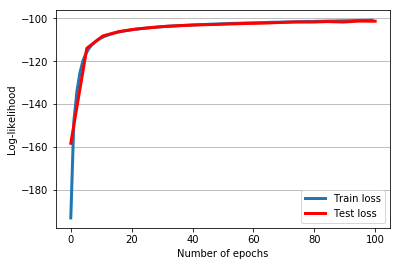

In [58]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.plot(np.array(train_elbo), linewidth=3, label='Train loss')
plt.plot(np.linspace(0, len(train_elbo), int(len(train_elbo)/TEST_FREQUENCY)),np.array(test_elbo), 
         linewidth=3, label='Test loss', color='r')
plt.grid(axis='y')

plt.xlabel('Number of epochs')
plt.ylabel('Log-likelihood')
plt.legend()